<a href="https://colab.research.google.com/github/serhataksoy/CompLightLab/blob/main/CompLightLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from getpass import getpass
import numpy as np
import cv2 as cv
import torch
import matplotlib.pyplot as plt
import torchvision.io
from torchvision.transforms import transforms
from PIL import Image
import math

In [ ]:
image = torchvision.io.read_image('/content/14135136623_3973d3f03c_z.jpg')
gray_img = torchvision.transforms.functional.rgb_to_grayscale(image)

In [ ]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.real(np.transpose(npimg, (1,2,0))), interpolation='gaussian')

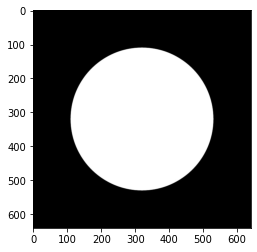

In [ ]:
plt.imshow(transforms.ToPILImage()(gray_img),"gray")

In [ ]:
gray_img.size()

torch.Size([1, 640, 640])

In [ ]:
def gaussianHP(D0,imgShape):
    dim = image.shape[0]
    rows, cols = image.shape[1:3]
    base = torch.zeros(1,rows,cols)
    center = (rows/2,cols/2)

    for x in range(cols):
        for y in range(rows):
            base[0][y][x] = 1 - math.exp(((-distance((y,x),center)**2)/(2*(D0**2))))
    return base

def gaussianLP(D0,imgShape):
    dim = image.shape[0]
    rows, cols = image.shape[1:3]
    base = torch.zeros(1,rows,cols)
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[0][y][x] = math.exp(((-distance((y,x),center)**2)/(2*(D0**2))))
    return base

In [ ]:
tr1 = transforms.ToTensor()
def distance(point1,point2):
    return math.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def ConvWithFFT(image):
  im1 = Image.Image.split(transforms.ToPILImage()(image))
  d,h,w = image.size()
  output = torch.zeros(image.size())
  for i in range(0,d):
    fft_img = torch.fft.fft2(tr1(im1[i]))
    im_fft = torch.fft.fftshift(fft_img)
    output[i] = im_fft.float() * gaussianLP(50,image.shape)
    output[i] = torch.fft.fftshift(output[i]) #i
    output[i] = torch.fft.ifft2(output[i])
    #output[i] = output[i]/output[i].real.max()
  plt.imshow(transforms.ToPILImage()(output),"gray")
  return output

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:239.)
  if sys.path[0] == '':


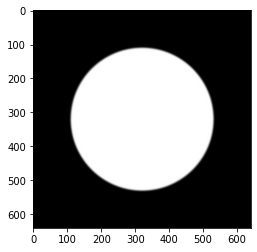

In [ ]:
blur = ConvWithFFT(gray_img)

In [ ]:
blur

tensor([[[-5.9467e-09, -6.6194e-08,  3.4142e-08,  ..., -9.5785e-08,
           5.5185e-08, -4.4177e-08],
         [-4.7493e-09, -6.4851e-08,  3.5035e-08,  ..., -9.5668e-08,
           5.6394e-08, -4.2815e-08],
         [-1.5856e-09, -6.1561e-08,  3.7605e-08,  ..., -9.4007e-08,
           5.9658e-08, -3.9471e-08],
         ...,
         [ 2.4853e-09, -5.7952e-08,  4.1982e-08,  ..., -8.7589e-08,
           6.3582e-08, -3.5935e-08],
         [-1.5856e-09, -6.2071e-08,  3.8151e-08,  ..., -9.1134e-08,
           5.9453e-08, -4.0143e-08],
         [-4.7493e-09, -6.5145e-08,  3.5280e-08,  ..., -9.4153e-08,
           5.6334e-08, -4.3182e-08]]])

In [ ]:
Rkernel = torch.randint(0,2,(640,640))

In [ ]:
Rkernel

tensor([[1, 0, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 1,  ..., 1, 0, 1],
        [1, 0, 1,  ..., 1, 1, 1],
        [1, 1, 0,  ..., 0, 1, 0]])

In [ ]:
image.size()

torch.Size([3, 640, 640])

In [ ]:
def ConvWithTorchF(image,kernel):
  im1 = Image.Image.split(transforms.ToPILImage()(image))
  channel = torchvision.transforms.functional.get_image_num_channels(image)
  width,height = torchvision.transforms.functional.get_image_size(image)
  KernelWidth,KernelHeight = torchvision.transforms.functional.get_image_size(kernel)
  FınalImg = torch.zeros((channel,height-KernelHeight+1,width-KernelWidth+1))
  
  for i in range(0,channel):
    FınalImg[i] = F.conv2d(tr1(im1[i]), kernel)
  plt.imshow(transforms.ToPILImage()(FınalImg))
  return FınalImg

In [ ]:
def kernelToWeight(kernel):
  kernel = kernel.view(1,1,3,3).repeat(1,1,1,1)
  return kernel

In [ ]:
def conv(img,kernel):
  channel = torchvision.transforms.functional.get_image_num_channels(img)
  width,height = torchvision.transforms.functional.get_image_size(img)
  KernelWidth,KernelHeight = torchvision.transforms.functional.get_image_size(kernel)
  FınalImg = torch.zeros((channel,height-KernelHeight+1,width-KernelWidth+1))

  for dim in range(channel):  
    for i in range(height-KernelHeight+1):
      for j in range(width-KernelWidth+1):
        sum = 0 
        for k in range(KernelHeight):
          for l in range(KernelWidth):
            sum += (img[dim][i+k][j+l])*(kernel[k,l])
        FınalImg[dim][i][j] = sum
  return FınalImg

In [ ]:
conv(blur,Rkernel)

tensor([[[-2.6975e-06, -2.8354e-06, -2.2465e-06,  ..., -5.9872e-07,
          -1.2559e-06, -1.5505e-06],
         [-2.6834e-06, -2.8142e-06, -2.2406e-06,  ..., -4.9527e-07,
          -1.1643e-06, -1.4599e-06],
         [-2.6530e-06, -2.7769e-06, -2.2177e-06,  ..., -3.7759e-07,
          -1.0583e-06, -1.3585e-06],
         ...,
         [-1.5399e-06, -1.6688e-06, -9.7781e-07,  ..., -1.4482e-06,
          -2.0073e-06, -2.2922e-06],
         [-1.6388e-06, -1.7632e-06, -1.0756e-06,  ..., -1.4492e-06,
          -2.0233e-06, -2.3015e-06],
         [-1.7921e-06, -1.9132e-06, -1.2352e-06,  ..., -1.4954e-06,
          -2.0844e-06, -2.3568e-06]],

        [[-2.6975e-06, -2.8354e-06, -2.2465e-06,  ..., -5.9872e-07,
          -1.2559e-06, -1.5505e-06],
         [-2.6834e-06, -2.8142e-06, -2.2406e-06,  ..., -4.9527e-07,
          -1.1643e-06, -1.4599e-06],
         [-2.6530e-06, -2.7769e-06, -2.2177e-06,  ..., -3.7759e-07,
          -1.0583e-06, -1.3585e-06],
         ...,
         [-1.5399e-06, -1

In [ ]:
RKernel

NameError: ignored

In [ ]:
Rkernel

tensor([[1, 1, 0,  ..., 1, 0, 1],
        [1, 1, 1,  ..., 1, 1, 0],
        [1, 1, 1,  ..., 1, 0, 0],
        ...,
        [1, 1, 0,  ..., 1, 0, 1],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 1,  ..., 1, 0, 1]])

In [ ]:
new = Rkernel * blur

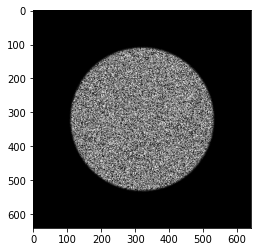

In [ ]:
plt.imshow(transforms.ToPILImage()(new),"gray")

In [ ]:
my_kernel = torch.ones(640,640)

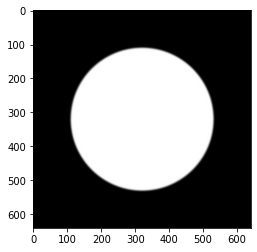

In [ ]:
plt.imshow(transforms.ToPILImage()(blur * my_kernel),'gray')

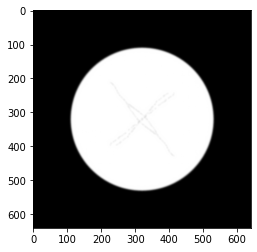

In [ ]:
goal_image = torchvision.io.read_image('/content/pixil-frame-0.jpg')
goal_img = torchvision.transforms.functional.rgb_to_grayscale(goal_image)
goal_img = ConvWithFFT(goal_img)

In [ ]:
goal_img.size()

torch.Size([1, 640, 640])

In [ ]:
blur = torch.round(blur, decimals = 2)

In [ ]:
error = goal_img - blur

In [ ]:
error

tensor([[[ 2.7250e-08, -3.4234e-08, -2.2861e-07,  ..., -1.8893e-08,
          -2.4539e-07, -5.4700e-08],
         [ 2.4868e-08, -3.6016e-08, -2.3110e-07,  ..., -2.1095e-08,
          -2.4834e-07, -5.7842e-08],
         [ 1.9151e-08, -4.0988e-08, -2.3666e-07,  ..., -2.6360e-08,
          -2.5470e-07, -6.4112e-08],
         ...,
         [ 1.2827e-08, -4.8861e-08, -2.4197e-07,  ..., -3.2242e-08,
          -2.5819e-07, -6.6793e-08],
         [ 1.9151e-08, -4.2888e-08, -2.3608e-07,  ..., -2.6426e-08,
          -2.5246e-07, -6.1081e-08],
         [ 2.4868e-08, -3.7045e-08, -2.3072e-07,  ..., -2.1116e-08,
          -2.4726e-07, -5.6209e-08]]])

In [ ]:
kernel = torch.round(kernel, decimals = 2)

In [ ]:
kernel += abs(kernel.min())

In [ ]:
kernel.min()

tensor(-0.1200)

In [ ]:
kernel.max()

tensor(0.1300)

In [ ]:
kernel.size()

torch.Size([1, 640, 640])

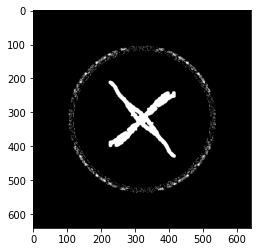

In [ ]:
plt.imshow(transforms.ToPILImage()(kernel),"gray")

In [ ]:
def kernelCorrection(kernel):
  width,height = torchvision.transforms.functional.get_image_size(kernel)
  for i in range(height):
    for j in range(width):
      if kernel[0][i][j] != 0:
        kernel[0][i][j] = 1
  return kernel

In [ ]:
kernel = kernelCorrection(kernel)

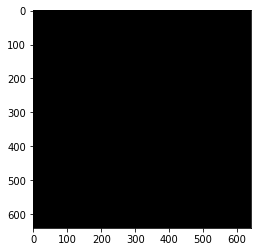

In [ ]:
plt.imshow(transforms.ToPILImage()(kernel),"gray")

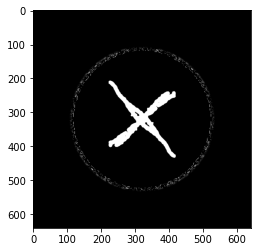

In [ ]:
plt.imshow(transforms.ToPILImage()(blur*kernel),"gray")

In [ ]:
kernel = torch.round(kernel,decimals = 2)

RuntimeError: ignored

In [ ]:
def kernelOpt(image,goal_image):


tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)